
# Agents ReAct dans LangGraph : météo + calendrier

Objectifs de ce notebook:

- Construire un **agent ReAct** utilisant deux outils : `météo` et `calendrier`.
- Construire **le même comportement** avec **LangGraph** (mais workflow explicite cette fois).
- Comparer les deux approches sur plusieurs requêtes utilisateur.
- Observabilité avec LangSmith

## 0. Setup du graphe

On utilise :
- un LLM via `langchain-openai`
- deux outils **simulés** (pas d’API externe) :
  - `fake_get_weather` : météo simple
  - `fake_calendar_query` : créneaux d’agenda simulés


In [ ]:

from typing import TypedDict, Optional, List, Literal
from datetime import datetime

import os

from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain.agents import create_react_agent, AgentExecutor

from langgraph.graph import StateGraph, END

# Configuration LangSmith pour le suivi des traces
# IMPORTANT: Configurez vos propres clés API dans vos variables d'environnement
# Vous pouvez les définir via un fichier .env ou en les exportant dans votre shell:
# export OPENAI_API_KEY="your-key-here"
# export LANGCHAIN_API_KEY="your-key-here"
# export LANGCHAIN_PROJECT="your-project-name"
# export LANGSMITH_ENDPOINT="https://api.smith.langchain.com"
# export LANGSMITH_TRACING="true"

# Vérification que les clés sont définies
if "OPENAI_API_KEY" not in os.environ:
    raise ValueError("OPENAI_API_KEY doit être définie dans vos variables d'environnement. "
                     "Voir le README.md pour les instructions de configuration.")

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


In [4]:

# Outil météo simulé
def fake_get_weather(period: str) -> str:
    """Simule une API météo pour 'matin', 'apres-midi' ou 'journee'."""
    if period == "matin":
        return "Ce matin : 4°C, ressenti 0°C, ciel couvert."
    elif period == "apres-midi":
        return "Cet après-midi : 16°C, pluie à partir de 15h."
    elif period == "soir":
        return "Ce soir : 9°C, orages."
    else:
        return "Aujourd'hui : entre 4°C et 16°C, avec quelques éclaircies."

# Agenda simulé : créneaux disponibles pour Julie
FAKE_SLOTS = [
    {"jour": "jeudi", "creneau": "14h-15h", "personne": "julie"},
    {"jour": "jeudi", "creneau": "16h-17h", "personne": "gabriel"},
    {"jour": "vendredi", "creneau": "10h-11h", "personne": "julie"},
]

def fake_calendar_query(person: str , jour: Optional[str] = None) -> str:
    """Renvoie des créneaux simulés pour une personne donnée."""
    slots = [s for s in FAKE_SLOTS if s["personne"].lower() == person.lower()]
    if jour:
        slots = [s for s in slots if s["jour"].lower() == jour.lower()]
    if not slots:
        return f"Aucun créneau disponible pour {person}."
    return "Créneaux disponibles pour {person} : " + ", ".join(
        f"{s['jour']} {s['creneau']}" for s in slots
    )


In [5]:
QUERIES = [
    "Je veux connaître la météo de cet après-midi.",
    "Peux-tu me proposer un créneau avec Julie cette semaine ?",
    "S'il fait beau jeudi après-midi, propose-moi un créneau avec Julie.",
]

## 1. Agent ReAct (boîte noire pratique)

On crée un agent ReAct LangChain avec deux outils :

- `weather_tool(period: str)` → appelle `fake_get_weather`
- `calendar_tool(person: str, jour: Optional[str])` → appelle `fake_calendar_query`

Le framework pilote la boucle **Thought → Action → Observation**.


In [7]:

@tool
def weather_tool(period: str) -> str:
    """Donne la météo simulée pour 'matin', 'apres-midi', 'soir' ou 'journee'."""
    return fake_get_weather(period)

@tool
def calendar_tool(person: str = "Julie", jour: Optional[str] = None) -> str:
    """Renvoie des créneaux simulés pour une personne (par défaut Julie)."""
    return fake_calendar_query(person=person, jour=jour)

tools = [weather_tool, calendar_tool]


In [8]:

# Utilisation du prompt ReAct standard de LangChain
# Ce prompt est conçu pour fonctionner correctement avec le parser ReAct
try:
    from langchain import hub
    # Récupération du prompt ReAct standard depuis LangChain Hub
    prompt = hub.pull("hwchase17/react")
except Exception:
    # Si hub.pull ne fonctionne pas, on utilise un prompt personnalisé avec le format exact ReAct
    from langchain_core.prompts import PromptTemplate
    template = """Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}"""
    prompt = PromptTemplate.from_template(template)

react_agent = create_react_agent(llm, tools, prompt)
# handle_parsing_errors=True permet à l'agent de réessayer en cas d'erreur de parsing
react_executor = AgentExecutor(agent=react_agent, tools=tools, verbose=True, handle_parsing_errors=True)


In [9]:
print("### Démo agent ReAct (boîte noire) ###")
for q in QUERIES:
    print(f"\n=== Question: {q}")
    result = react_executor.invoke({"input": q})
    print("Réponse finale (ReAct):", result["output"])


### Démo agent ReAct (boîte noire) ###

=== Question: Je veux connaître la météo de cet après-midi.


> Entering new AgentExecutor chain...
Je dois obtenir la météo simulée pour cet après-midi. 
Action: weather_tool 
Action Input: 'apres-midi' Aujourd'hui : entre 4°C et 16°C, avec quelques éclaircies.Je sais maintenant que la météo de cet après-midi est entre 4°C et 16°C, avec quelques éclaircies.
Final Answer: La météo de cet après-midi est entre 4°C et 16°C, avec quelques éclaircies.

> Finished chain.
Réponse finale (ReAct): La météo de cet après-midi est entre 4°C et 16°C, avec quelques éclaircies.

=== Question: Peux-tu me proposer un créneau avec Julie cette semaine ?


> Entering new AgentExecutor chain...
Je vais vérifier les créneaux disponibles pour Julie cette semaine.  
Action: calendar_tool  
Action Input: 'Julie'  Aucun créneau disponible pour 'Julie'.Je vais essayer de vérifier les créneaux pour une autre personne ou voir si je peux obtenir des informations sur une autre

## 4. Agent LangGraph (workflow explicite)

On reconstruit le **même comportement** avec LangGraph :

1. Interpréter la demande (intent + paramètres)
2. Décider quels outils appeler (météo, calendrier, les deux)
3. Appeler les outils
4. Composer la réponse finale


In [10]:

IntentType = Literal["weather", "calendar", "both", "none"]

class AgentState(TypedDict):
    user_input: str
    intent: IntentType
    period: Optional[str]
    person: Optional[str]
    day: Optional[str]
    weather_result: Optional[str]
    calendar_result: Optional[str]
    final_answer: Optional[str]


In [11]:

def interpret_request(state: AgentState) -> AgentState:
    """Utilise le LLM pour classifier la demande et extraire quelques paramètres."""
    user_input = state["user_input"]
    prompt = ChatPromptTemplate.from_template(
        """Tu analyses la demande utilisateur et tu renvoies un JSON.

Demande: {user_input}

Répond UNIQUEMENT avec un JSON de la forme :
{{
  "intent": "weather" | "calendar" | "both" | "none",
  "period": "matin" | "apres-midi" | "soir" | "journee" | null,
  "person": string ou null,
  "day": string ou null
}}
"""
    )
    messages = prompt.format_messages(user_input=user_input)
    raw = llm.invoke(messages).content
    import json
    try:
        parsed = json.loads(raw)
    except json.JSONDecodeError:
        parsed = {"intent": "none", "period": None, "person": None, "day": None}

    state["intent"] = parsed.get("intent", "none")
    state["period"] = parsed.get("period")
    state["person"] = parsed.get("person")
    state["day"] = parsed.get("day")
    return state


In [12]:

def call_weather_node(state: AgentState) -> AgentState:
    period = state.get("period") or "journee"
    state["weather_result"] = fake_get_weather(period)
    return state


In [13]:

def call_calendar_node(state: AgentState) -> AgentState:
    person = state.get("person")
    day = state.get("day")
    state["calendar_result"] = fake_calendar_query(person=person, jour=day)
    return state


In [14]:

from typing import List

def build_final_answer(state: AgentState) -> AgentState:
    parts: List[str] = []
    if state.get("weather_result"):
        parts.append(state["weather_result"])
    if state.get("calendar_result"):
        parts.append(state["calendar_result"])
    if not parts:
        parts.append("Je ne suis pas sûr de comprendre ta demande.")

    state["final_answer"] = " ".join(parts)
    return state


In [15]:

graph = StateGraph(AgentState)

graph.add_node("interpret", interpret_request)
graph.add_node("weather", call_weather_node)
graph.add_node("calendar", call_calendar_node)
graph.add_node("final", build_final_answer)

graph.set_entry_point("interpret")

def route_from_intent(state: AgentState):
    intent = state.get("intent", "none")
    if intent == "weather":
        return "weather"
    if intent == "calendar":
        return "calendar"
    if intent == "both":
        return "weather"
    return "final"

graph.add_conditional_edges(
    "interpret",
    route_from_intent,
    {
        "weather": "weather",
        "calendar": "calendar",
        "both": "weather",
        "final": "final",
    },
)

def after_weather(state: AgentState):
    if state.get("intent") == "both":
        return "calendar"
    return "final"

graph.add_conditional_edges(
    "weather",
    after_weather,
    {
        "calendar": "calendar",
        "final": "final",
    },
)

graph.add_edge("calendar", "final")
graph.add_edge("final", END)

app = graph.compile()


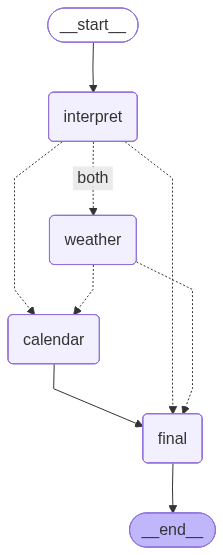

In [16]:
g = app.get_graph()

from IPython.display import Image
Image(g.draw_mermaid_png())

In [17]:

print("### Démo agent LangGraph (workflow explicite) ###")
for q in QUERIES:
    print(f"\n=== Question: {q}")
    initial_state: AgentState = {
        "user_input": q,
        "intent": "none",
        "period": None,
        "person": None,
        "day": None,
        "weather_result": None,
        "calendar_result": None,
        "final_answer": None,
    }
    result = app.invoke(initial_state)
    print("Réponse finale (LangGraph):", result["final_answer"])


### Démo agent LangGraph (workflow explicite) ###

=== Question: Je veux connaître la météo de cet après-midi.
Réponse finale (LangGraph): Cet après-midi : 16°C, pluie à partir de 15h.

=== Question: Peux-tu me proposer un créneau avec Julie cette semaine ?
Réponse finale (LangGraph): Aucun créneau disponible pour Julie.

=== Question: S'il fait beau jeudi après-midi, propose-moi un créneau avec Julie.
Réponse finale (LangGraph): Cet après-midi : 16°C, pluie à partir de 15h. Créneaux disponibles pour {person} : jeudi 14h-15h



## 5. Comparaison rapide : ReAct vs LangGraph

Sur ce petit exemple :

- **ReAct** :
  - On donne les outils et un prompt ReAct.
  - Le framework pilote la boucle Thought → Action → Observation.
  - Le workflow reste implicite (on le devine via les logs ou LangSmith).

- **LangGraph** :
  - On définit explicitement les étapes (interpréter, météo, calendrier, réponse).
  - On contrôle les transitions (ex : `intent == "both"` → météo puis calendrier).
  - Le même agent devient testable, observable, modifiable nœud par nœud.

En production, on peut ensuite :
- Ajouter des garde-fous,
- Limiter certains outils à certains chemins,
- Brancher LangSmith pour suivre les coûts, la latence et les erreurs par nœud.
